In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
import os
import cv2
import keras
from keras.models import Model
from os import listdir
from os.path import join
from random import shuffle
from tqdm import tqdm 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.models import load_model
import random

Using TensorFlow backend.


In [4]:
!unzip -I "utf-8" "/content/gdrive/My Drive/Project/Distracted-driver-detection.zip" -d "/content/DL_Project"

Archive:  /content/gdrive/My Drive/Project/Distracted-driver-detection.zip
replace /content/DL_Project/driver_imgs_list.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
import pandas as pd
df = pd.read_csv("/content/DL_Project/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
from skimage import io
from skimage import color
train_image = []
image_label = []

print("Getting data from folders:")
for i in range(10):
    print('c',i)
    imgs = os.listdir("/content/DL_Project/imgs/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/DL_Project/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = cv2.resize(img,(150,150))
        label = i
        driver = df[df['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)
        shuffle(train_image)

Getting data from folders:
c 0
c 1
c 2
c 3
c 4
c 5
c 6
c 7
c 8
c 9


In [0]:
driver_sel = ['p012', 'p049', 'p066', 'p081']

In [8]:
x_train= []
y_train = []
x_val = []
y_val = []

for features,labels,drivers in train_image:
        if drivers in driver_sel:
          x_val.append(features)
          y_val.append(labels)
    
        else:
          x_train.append(features)
          y_train.append(labels)
    
print (len(x_train), len(y_train))
print (len(x_val), len(y_val))

18733 18733
3691 3691


In [9]:
import numpy as np
x_train = np.array(x_train).reshape(-1,150,150,3)
y_train = to_categorical(y_train)
x_val = np.array(x_val).reshape(-1,150,150,3)
y_val = to_categorical(y_val)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(18733, 150, 150, 3)
(18733, 10)
(3691, 150, 150, 3)
(3691, 10)


In [0]:
#Normalizing and rescaling the images 1./255
from keras.preprocessing.image import ImageDataGenerator
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40, width_shift_range = 0.3, height_shift_range = 0.3, shear_range = 0.3, zoom_range = 0.2, horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 128)
val_generator = val_datagen.flow(x_val, y_val, batch_size = 128)

In [11]:
from keras.applications.vgg16 import VGG16

VGG_model = VGG16(weights='imagenet', include_top= False)

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [12]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

x = VGG_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation = 'softmax')(x)

out_VGG_model = Model(inputs=VGG_model.input,outputs=x)

out_VGG_model.compile(optimizer= 'SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = out_VGG_model.fit_generator(train_generator, epochs= 15, verbose=1, steps_per_epoch=len(x_train)//128, validation_data= val_generator, validation_steps= len(x_val)//128)

Epoch 1/15
146/146 [==============================] - 91s 624ms/step - loss: 2.1343 - accuracy: 0.2375 - val_loss: 1.8694 - val_accuracy: 0.3638
Epoch 2/15
146/146 [==============================] - 88s 606ms/step - loss: 1.5160 - accuracy: 0.4841 - val_loss: 0.9969 - val_accuracy: 0.6932
Epoch 3/15
146/146 [==============================] - 87s 596ms/step - loss: 0.7907 - accuracy: 0.7374 - val_loss: 1.1048 - val_accuracy: 0.7269
Epoch 4/15
146/146 [==============================] - 87s 596ms/step - loss: 0.4427 - accuracy: 0.8579 - val_loss: 0.5470 - val_accuracy: 0.8142
Epoch 5/15
146/146 [==============================] - 86s 592ms/step - loss: 0.3133 - accuracy: 0.8980 - val_loss: 0.5333 - val_accuracy: 0.8667
Epoch 6/15
146/146 [==============================] - 86s 587ms/step - loss: 0.2533 - accuracy: 0.9219 - val_loss: 0.6931 - val_accuracy: 0.8740
Epoch 7/15
146/146 [==============================] - 86s 590ms/step - loss: 0.2321 - accuracy: 0.9293 - val_loss: 0.7509 - val_ac

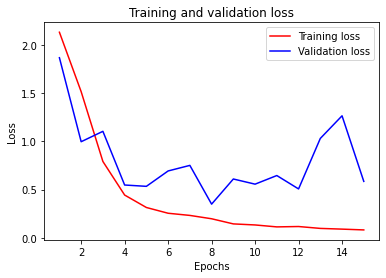

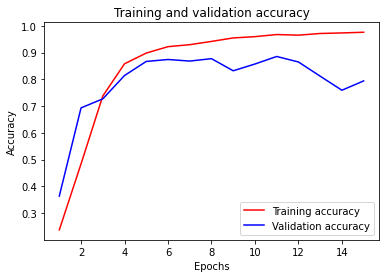

In [13]:
out_VGG_model.save('vgg.hdf5')
out_VGG_model = load_model('vgg.hdf5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting losses
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plotting accuracies
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
from keras.applications import MobileNet
mnet_model = MobileNet(weights='imagenet', include_top= False)

mnet_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________

In [0]:
y = mnet_model.output
y = GlobalAveragePooling2D()(y)
y = Dense(10, activation = 'softmax')(y)

out_mnet_model = Model(inputs=mnet_model.input,outputs=y)

out_mnet_model.compile(optimizer= 'SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = out_mnet_model.fit_generator(train_generator, epochs= 15, verbose=1, steps_per_epoch=len(x_train)//128, validation_data= val_generator, validation_steps= len(x_val)//128)

Epoch 1/15
146/146 [==============================] - 95s 652ms/step - loss: 1.4791 - accuracy: 0.5064 - val_loss: 1.5824 - val_accuracy: 0.5246
Epoch 2/15
146/146 [==============================] - 94s 643ms/step - loss: 0.5565 - accuracy: 0.8266 - val_loss: 1.0033 - val_accuracy: 0.6638
Epoch 3/15
146/146 [==============================] - 93s 634ms/step - loss: 0.3538 - accuracy: 0.8944 - val_loss: 0.9338 - val_accuracy: 0.7157
Epoch 4/15
146/146 [==============================] - 93s 637ms/step - loss: 0.2715 - accuracy: 0.9187 - val_loss: 1.1318 - val_accuracy: 0.7286
Epoch 5/15
146/146 [==============================] - 92s 632ms/step - loss: 0.2196 - accuracy: 0.9343 - val_loss: 0.7113 - val_accuracy: 0.7328
Epoch 6/15
146/146 [==============================] - 92s 632ms/step - loss: 0.1845 - accuracy: 0.9445 - val_loss: 0.9137 - val_accuracy: 0.7513
Epoch 7/15
146/146 [==============================] - 92s 627ms/step - loss: 0.1632 - accuracy: 0.9522 - val_loss: 0.9292 - val_ac

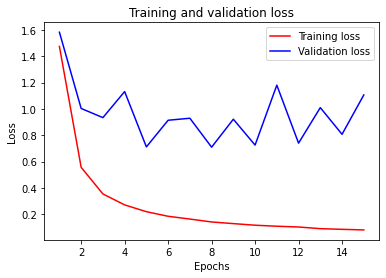

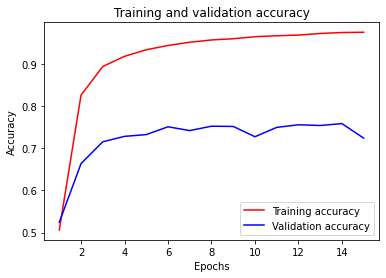

In [0]:
out_mnet_model.save('mnet.hdf5')
out_mnet_model = load_model('mnet.hdf5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting losses
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plotting accuracies
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
from keras.applications import ResNet50
rnet_model = ResNet50(weights='imagenet', include_top= False)

rnet_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________

In [0]:
z = rnet_model.output
z = GlobalAveragePooling2D()(z)
z = Dense(10, activation = 'softmax')(z)

out_rnet_model = Model(inputs=rnet_model.input,outputs=z)

out_rnet_model.compile(optimizer= 'SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = out_rnet_model.fit_generator(train_generator, epochs= 15, verbose=1, steps_per_epoch=len(x_train)//128, validation_data= val_generator, validation_steps= len(x_val)//128)

Epoch 1/15
146/146 [==============================] - 179s 1s/step - loss: 1.3401 - accuracy: 0.5760 - val_loss: 2.5314 - val_accuracy: 0.0765
Epoch 2/15
146/146 [==============================] - 177s 1s/step - loss: 0.3391 - accuracy: 0.9056 - val_loss: 2.4950 - val_accuracy: 0.1050
Epoch 3/15
146/146 [==============================] - 175s 1s/step - loss: 0.1936 - accuracy: 0.9439 - val_loss: 2.4359 - val_accuracy: 0.1036
Epoch 4/15
146/146 [==============================] - 174s 1s/step - loss: 0.1389 - accuracy: 0.9585 - val_loss: 2.5357 - val_accuracy: 0.1083
Epoch 5/15
146/146 [==============================] - 173s 1s/step - loss: 0.1083 - accuracy: 0.9683 - val_loss: 2.0904 - val_accuracy: 0.2489
Epoch 6/15
146/146 [==============================] - 174s 1s/step - loss: 0.0910 - accuracy: 0.9747 - val_loss: 2.1524 - val_accuracy: 0.4822
Epoch 7/15
146/146 [==============================] - 174s 1s/step - loss: 0.0772 - accuracy: 0.9765 - val_loss: 1.2716 - val_accuracy: 0.6278

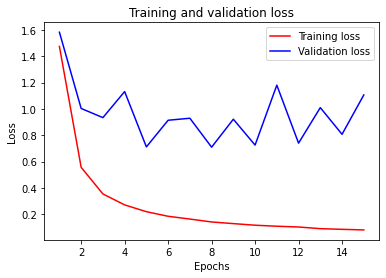

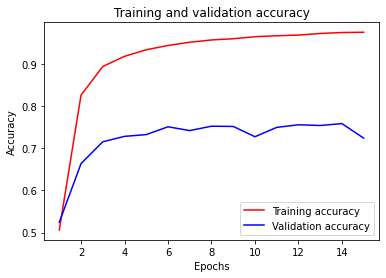

In [0]:
out_mnet_model.save('rnet.hdf5')
out_mnet_model = load_model('rnet.hdf5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting losses
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plotting accuracies
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#Creating CNN
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', input_shape= (150,150,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer= 'Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_generator, epochs= 20, verbose=1, steps_per_epoch=len(x_train)//128, validation_data= val_generator, validation_steps= len(x_val)//128)

Epoch 1/20
146/146 [==============================] - 93s 638ms/step - loss: 2.3207 - accuracy: 0.1392 - val_loss: 2.3611 - val_accuracy: 0.1035
Epoch 2/20
146/146 [==============================] - 92s 631ms/step - loss: 2.0356 - accuracy: 0.2465 - val_loss: 3.8079 - val_accuracy: 0.1069
Epoch 3/20
146/146 [==============================] - 92s 631ms/step - loss: 1.6600 - accuracy: 0.3857 - val_loss: 2.2684 - val_accuracy: 0.2885
Epoch 4/20
146/146 [==============================] - 93s 635ms/step - loss: 1.3501 - accuracy: 0.5011 - val_loss: 2.5214 - val_accuracy: 0.2832
Epoch 5/20
146/146 [==============================] - 92s 630ms/step - loss: 1.1290 - accuracy: 0.5869 - val_loss: 2.8547 - val_accuracy: 0.2372
Epoch 6/20
146/146 [==============================] - 92s 632ms/step - loss: 0.9378 - accuracy: 0.6639 - val_loss: 1.6407 - val_accuracy: 0.3433
Epoch 7/20
146/146 [==============================] - 92s 630ms/step - loss: 0.7835 - accuracy: 0.7256 - val_loss: 1.4563 - val_ac

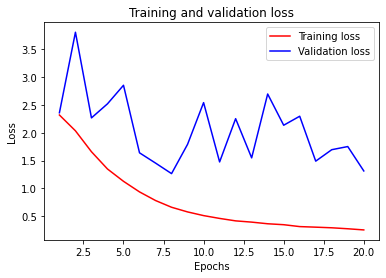

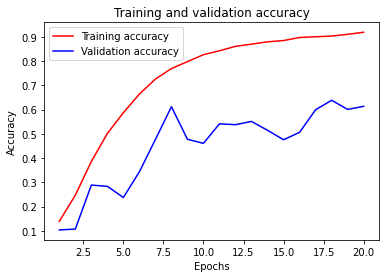

In [0]:
model.save('cnn.hdf5')
model = load_model('cnn.hdf5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting losses
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plotting accuracies
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
a = VGG_model.output
a = GlobalAveragePooling2D()(a)
a = Dense(1028,activation='relu')(a) 
a = Dropout(0.25)(a)  
a = Dense(512,activation='relu')(a) 
a = BatchNormalization()(a)
a = Dropout(0.5)(a)
a = Dense(256,activation='relu')(a)
a = BatchNormalization()(a)
a = Dropout(0.5)(a) 
a = Dense(10, activation = 'softmax')(a)

extra_VGG_model = Model(inputs=VGG_model.input,outputs=a)

extra_VGG_model.summary()

extra_VGG_model.compile(optimizer= 'SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = extra_VGG_model.fit_generator(train_generator, epochs= 15, verbose=1, steps_per_epoch=len(x_train)//128, validation_data= val_generator, validation_steps= len(x_val)//128)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

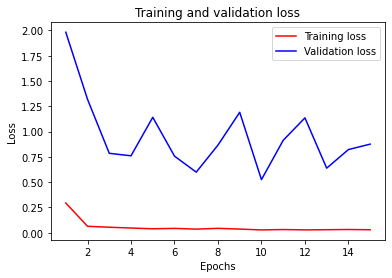

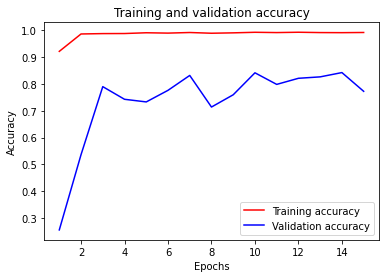

In [0]:
extra_VGG_model.save('evgg.hdf5')
extra_VGG_model = load_model('evgg.hdf5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting losses
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plotting accuracies
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
test_image = []
i = 0

print("Getting data for Test set:")
imgs = sorted(os.listdir('/content/DL_Project/imgs/test'))

for j in range(20):
    img_name = "/content/DL_Project/imgs/test"+"/"+imgs[j]
    img = cv2.imread(img_name)
    img = cv2.resize(img,(150,150))
    test_image.append(img)
    shuffle(test_image)
print("Data Extracted.")

Getting data for Test set:
Data Extracted.


In [0]:
test = []

for img in test_image:
    test.append(img)

In [21]:
out_VGG_model = load_model('vgg.hdf5')
test = np.array(test).reshape(-1,150,150,3)
prediction = out_VGG_model.predict(test)
prediction[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
categories = {"c0": "normal driving",
"c1": "texting - right",
"c2": "talking on the phone - right",
"c3": "texting - left",
"c4": "talking on the phone - left",
"c5": "operating the radio",
"c6": "drinking",
"c7": "reaching behind",
"c8": "hair and makeup",
"c9": "talking to passenger" }

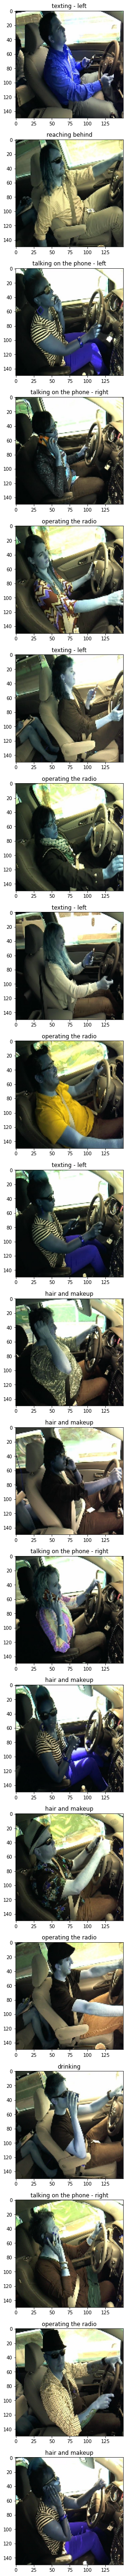

In [23]:
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'c'+ str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(categories[predicted_class])
    plt.show

In [6]:
f_test_image = []
flag = 0
l = 0

print("Loading the test data:")
imgs = sorted(os.listdir('/content/DL_Project/imgs/test'))
for j in range(len(imgs)):
    img_name = "/content/DL_Project/imgs/test"+"/"+imgs[j]
    img = cv2.imread(img_name)
    img = cv2.resize(img,(150,150))
    f_test_image.append(img)
    flag = flag+1
    if flag == 1000:
        l = l+1
        flag = 0

print('All images are loaded')

Loading the test data:
All images are loaded


In [7]:
X_test = []
Y_test = []
for features in f_test_image:
    X_test.append(features)
    #Y_test.append(features)

print (len(X_test))
#print(len(Y_test))

79726


In [8]:
X_test = np.array(X_test).reshape(-1,150,150,3)
#Y_test = to_categorical(Y_test)
print (X_test.shape)
#print(Y_test.shape)

(79726, 150, 150, 3)


In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
model_predict = []
predict_class = []

out_VGG_model = load_model('vgg.hdf5')
model_predict = out_VGG_model.predict(X_test)
print('Number of Images Predicted:',len(model_predict))

df_predict = pd.DataFrame(model_predict)
df_predict['Images'] = pd.Series(imgs)
df_predict.to_csv('Predictions.csv')

Number of Images Predicted: 79726
